<a href="https://colab.research.google.com/github/karthikeyansura/store-sales-time-series-modeling/blob/data-preprocessing-BhanuHarshaY/store_sales_time_series_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Store Sales - Time Series Forecasting**

In [14]:
# Core libraries
import numpy as np
import pandas as pd
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold, RFE
from sklearn.ensemble import RandomForestRegressor

# For Autoencoder (embedding-based feature selection)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')


print("All libraries imported successfully!")

All libraries imported successfully!


#### **To run this notebook, you need your personal Kaggle API credentials. Follow these steps to generate them:**

1.   Log into **[Kaggle.com](https://www.kaggle.com)**.
2.   Click your profile picture in the top-right corner and select **Settings**.
3. **Username:** Your username is listed at the top of the Account tab.
4. Scroll down to the **"Legacy API Credentials"** section and click on **"Create Legacy API Key"**
5. A file named `kaggle.json` will download to your computer. Open that and copy the random string found inside the `"key": "..."` section and Replace `"ENTER_YOUR_KEY_HERE"` and replace `"ENTER_YOUR_USERNAME_HERE"` with your actual username.



In [2]:
import os

# LOADING THE DATASET

# Kaggle API configuration
os.environ['KAGGLE_USERNAME'] = "ENTER_YOUR_USERNAME_HERE"
os.environ['KAGGLE_KEY'] = "ENTER_YOUR_KEY_HERE"

# setup paths
COMP_NAME = 'store-sales-time-series-forecasting'
BASE_PATH = f'/content/{COMP_NAME}/'

# download files
if not os.path.exists(BASE_PATH):
    print(f"Downloading {COMP_NAME}...")
    !mkdir -p {BASE_PATH}

    !mkdir -p ~/.kaggle
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
        f.write('{"username":"' + os.environ['KAGGLE_USERNAME'] + '","key":"' + os.environ['KAGGLE_KEY'] + '"}')
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle competitions download -c {COMP_NAME} -p {BASE_PATH}
    !unzip -q {BASE_PATH}{COMP_NAME}.zip -d {BASE_PATH}
    !rm {BASE_PATH}{COMP_NAME}.zip
    print("Download complete.")
else:
    print("Data already downloaded.")

# load dataset into df
train = pd.read_csv(BASE_PATH + 'train.csv', parse_dates=['date'])
test = pd.read_csv(BASE_PATH + 'test.csv', parse_dates=['date'])
stores = pd.read_csv(BASE_PATH + 'stores.csv')
oil = pd.read_csv(BASE_PATH + 'oil.csv', parse_dates=['date'])
holidays = pd.read_csv(BASE_PATH + 'holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv(BASE_PATH + 'transactions.csv', parse_dates=['date'])

print(f"Train shape: {train.shape}")
print("All datasets loaded successfully!")

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 1.64GB/s]
Download complete.
Train shape: (3000888, 6)
All datasets loaded successfully!


**Rationale:** We selected this method to load the dataset because it allows the entire team to execute the code easily without requiring manual directory management on local machines. Rather than relying on individual file downloads or identical Google Drive configurations, this script automatically retrieves the data directly from Kaggle into the notebook environment at runtime.

### **1. DATASET OVERVIEW**

Dataset Overview
Total number of samples in train dataset: 3000888
Total number of samples in test dataset: 28512
Total number of samples: 3029400
Total number of features: 5 features + 1 target variable (sales)

Supplementary Datasets Overview
Stores dataset shape: (54, 5)
Oil dataset shape: (1218, 2)
Holidays dataset shape: (350, 6)
Transactions dataset shape: (83488, 3)
Stores metadata: 54 stores with 5 features
Oil prices: 1218 daily records
Holidays: 350 holidays
Transactions: 83488 records

Train Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None

First 5 

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0



Data Distribution of target class Sales:


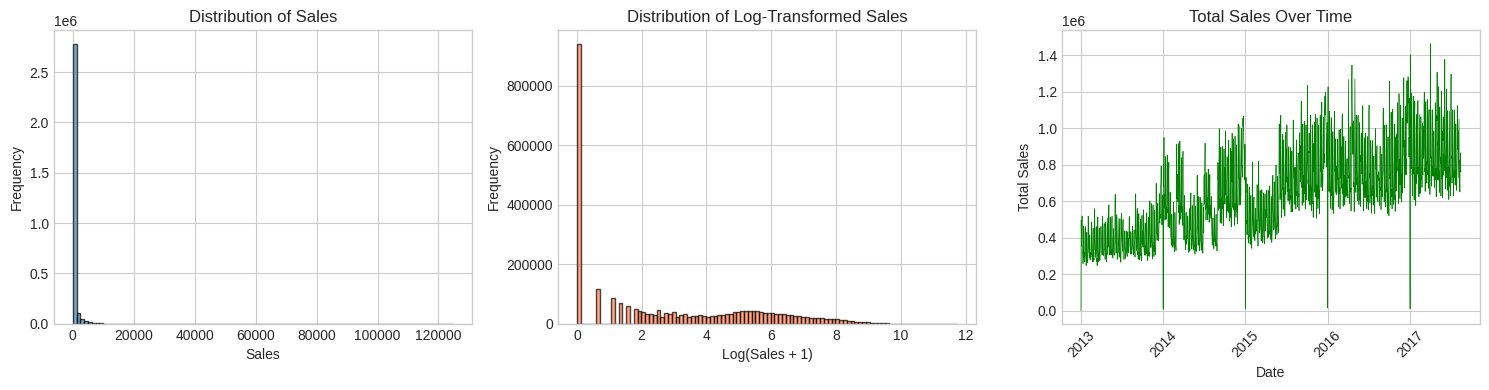


Statistical Summary of Target Class (sales):
count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

Key Observations regarding sales:
  - Sales range: 0.00 to 124717.00
  - Mean sales: 357.78
  - Median sales: 11.00
  - Zero sales records: 939,130 (31.30%)

Feature data type Analysis:

Train Dataset:
----------------------------------------
  id                   | int64           | Numerical (Continuous)         | Unique: 3000888
  date                 | datetime64[ns]  | Temporal (Date)                | Unique: 1684
  store_nbr            | int64           | Numerical (Continuous)         | Unique: 54
  family               | object          | Categorical (Nominal)          | Unique: 33
  sales                | float64         | Numerical (Continuous)         | Unique: 379610
  onpromotion          | int64           | Numerical (Contin

In [3]:
# 1. DATASET AND DESCRIPTIONS

print(f"Dataset Overview")
total_train_samples = len(train)
total_test_samples = len(test)
num_features = train.shape[1] - 1

print(f"Total number of samples in train dataset: {total_train_samples}")
print(f"Total number of samples in test dataset: {total_test_samples}")
print(f"Total number of samples: {total_train_samples + total_test_samples}")
print(f"Total number of features: {num_features} features + 1 target variable (sales)")

# supplementary datasets overview
print("\nSupplementary Datasets Overview")
print(f"Stores dataset shape: {stores.shape}")
print(f"Oil dataset shape: {oil.shape}")
print(f"Holidays dataset shape: {holidays.shape}")
print(f"Transactions dataset shape: {transactions.shape}")
print(f"Stores metadata: {len(stores)} stores with {stores.shape[1]} features")
print(f"Oil prices: {len(oil)} daily records")
print(f"Holidays: {len(holidays)} holidays")
print(f"Transactions: {len(transactions)} records")


# training data info
print("\nTrain Dataset Structure:")
print(train.info())
print("\nFirst 5 rows of training data:")
display(train.head())

# Data distribution of sales
print("\nData Distribution of target class Sales:")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution of sales
axes[0].hist(train['sales'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Sales')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Sales')


# Log-transformed distribution since we use RMSLE
train['log_sales'] = np.log1p(train['sales'])
axes[1].hist(train['log_sales'], bins=100, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Sales + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Log-Transformed Sales')

# Sales over time (aggregated)
daily_sales = train.groupby('date')['sales'].sum().reset_index()
axes[2].plot(daily_sales['date'], daily_sales['sales'], color='green', linewidth=0.5)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Total Sales')
axes[2].set_title('Total Sales Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary of  sales
print("\nStatistical Summary of Target Class (sales):")
print(train['sales'].describe())

print(f"\nKey Observations regarding sales:")
print(f"  - Sales range: {train['sales'].min():.2f} to {train['sales'].max():.2f}")
print(f"  - Mean sales: {train['sales'].mean():.2f}")
print(f"  - Median sales: {train['sales'].median():.2f}")
print(f"  - Zero sales records: {(train['sales'] == 0).sum():,} ({(train['sales'] == 0).mean()*100:.2f}%)")

# Feature analysis
print("\nFeature data type Analysis:")
def analyze_feature_types(df, name):
    print(f"\n{name}:")
    print("-" * 40)
    for col in df.columns:
        dtype = df[col].dtype
        nunique = df[col].nunique()

        if dtype == 'datetime64[ns]':
            ftype = "Temporal (Date)"
        elif dtype in ['int64', 'float64']:
            if nunique < 20:
                ftype = "Categorical (Encoded as Numeric)"
            else:
                ftype = "Numerical (Continuous)"
        elif dtype == 'object':
            ftype = "Categorical (Nominal)"
        elif dtype == 'bool':
            ftype = "Boolean"
        else:
            ftype = "Other"

        print(f"  {col:20} | {str(dtype):15} | {ftype:30} | Unique: {nunique}")

analyze_feature_types(train, "Train Dataset")
analyze_feature_types(stores, "Stores Dataset")
analyze_feature_types(oil, "Oil Dataset")
analyze_feature_types(holidays, "Holidays Dataset")
analyze_feature_types(transactions, "Transactions Dataset")


### **Discussion:**

The implemented code performs a comprehensive initial examination of the **"Store Sales - Time Series Forecasting"** dataset. It utilizes the `Pandas` library for `data structure manipulation` and `Matplotlib` for `visualizing` distributions.

1.   The code first **quantifies** the **scale** of the dataset by calculating the shapes of the `train (3M+ rows)` and `test sets`, as well as the four `supplementary datasets (stores, oil, holidays, transactions)`.
2.   By plotting both the `raw distribution` and the `Log-transformed distribution (np.log1p)`, the code **visually** depicts the extreme skewness of retail sales data. The inclusion of a `time-series plot (daily_sales) aggregates` sales by date, providing an immediate `visual check` for seasonality and trends over the `4-year period`.
3. The `analyze_feature_types` function automates the classification of data type of features . It intelligently distinguishes between `categorical features (like family or city), temporal features (date), and numerical features` based on data types and unique value counts.

### **Analysis:**


1.  **Dataset used :** We utilized the **"Store Sales - Time Series Forecasting(Kaggle Competition)"** dataset contains historical sales data from Corporación Favorita provided by **Favorita**, a major grocery retailer in Ecuador. The dataset is a relational database consisting of a primary training file and several supplementary metadata files(stores, oil, holidays, transactions)..
    *   The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers.
    * Link to the dataset: [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

2. **Samples in the dataset:**
    * **Train Samples:** 3,000,888 records.
    * **Test Samples:** 28,512 records
    *  **Total Samples:** 3,029,400 rows of time-series data.

3. **Labeled vs. Unlabeled data:**
    * The dataset is **labeled**, making this a **Supervised Learning regression task**. It is partitioned into a **training set** containing **3,000,888 labeled samples** where the target 'sales' is provided and a **test set** containing **28,512 unlabeled samples** where 'sales' must be predicted.

4. **About the Data:**
      * **Type of the data:** This is a **multivariate time-series dataset**. It combines *structured tabular data* (store IDs, product families) with *temporal sequences* (daily records).
      * **Dataset contains:** The data represents retail sales volume for specific product families at specific stores in Ecuador from 2013 to 2017. goal is to predict unit sales for thousands of product families sold at different Favorita stores.


5. **Data Distribution of the target variable `sales`:**
      * The data is highly **right-skewed**. The **mean sales (357.78)** is drastically higher than the **median (11.00)**, indicating a "long tail" of high-volume sales events.
      * A **substantial portion** of the data `(31.30%)` consists of `zero sales`. This suggests that many product families do not sell every day at every store, or the store was closed.
      * **Sales range** from `0 to a maximum of 124,717 units` in a single day for a product family.

6. **Dataset Feature Analysis:**
      * **Categorical (Nominal):**
           * `family` : 33 unique product categories (e.g., AUTOMOTIVE, BEVERAGES, BOOKS, BABY CARE, etc.).
           * `city` : 22 unique cities(e.g., Quito, Guayaquil, Santo Domingo, etc.) where stores are located.
           * `state` : 16 unique states(e.g., Pichincha, Guayas, Cotopaxi, etc.) where stores are located.
           * `type` : 5 store types (A, B, C, D, E).
           * `locale` : Scope of a holiday (Local, Regional, National).
           *  `type (holidays)` : Holiday type (Holiday, Event, etc.).
           *  `locale_name` : Name of locale (Ecuador, Quito, etc.).
           *  `description`: Holiday description
      * **Categorical (Ordinal):**
           * `cluster` : 17 clusters grouping similar stores (likely ordinal based on store size/demographics).
      * **Numerical (Continuous):**
           * `sales` : Target variable
           * `onpromotion` : The count of items on promotion for a specific family/store/date.
           * `transactions`: Total transactions at a store per day.
           * `dcoilwtico` : Daily oil price.
      * **Temporal:**
           * `date` : Date of record, ranging from 2013-01-01 to 2017-08-15.

      * **Identifier:**
           *  **id:** Unique record identifier
           *  **store_nbr:** Store identifier


**NOTE:** As we are dealing TABULAR/TIME SERIES data. No images, audio, or text requiring special preprocessing (tokenization, MFCCs, etc.) are present in this dataset.

      


### **2. DATA PRE-PROCESSING**

Merged Dataset:
Shape after merging datasets: (3000888, 13)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'log_sales', 'city', 'state', 'type', 'cluster', 'dcoilwtico', 'transactions']
Missing Value Analysis and Handling

Missing Values Before Treatment:
              Missing Count  Percentage
dcoilwtico           928422       30.94
transactions         245784        8.19

Oil prices (dcoilwtico):
  Missing values before: 928422
  Missing values after (ffill + bfill): 0

Transactions:
  Missing values before: 245784
  Missing values after (group median imputation): 0

Missing Values After Handling:
0 total missing values

Handling Categorical Variables

Categorical columns to encode: ['family', 'city', 'state', 'type']

family: 33 unique values
  Sample: ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS']

city: 22 unique values
  Sample: ['Quito' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra']

state: 16 unique values
  Sample: ['Pichincha' 'Cotopaxi' 'Chimbora

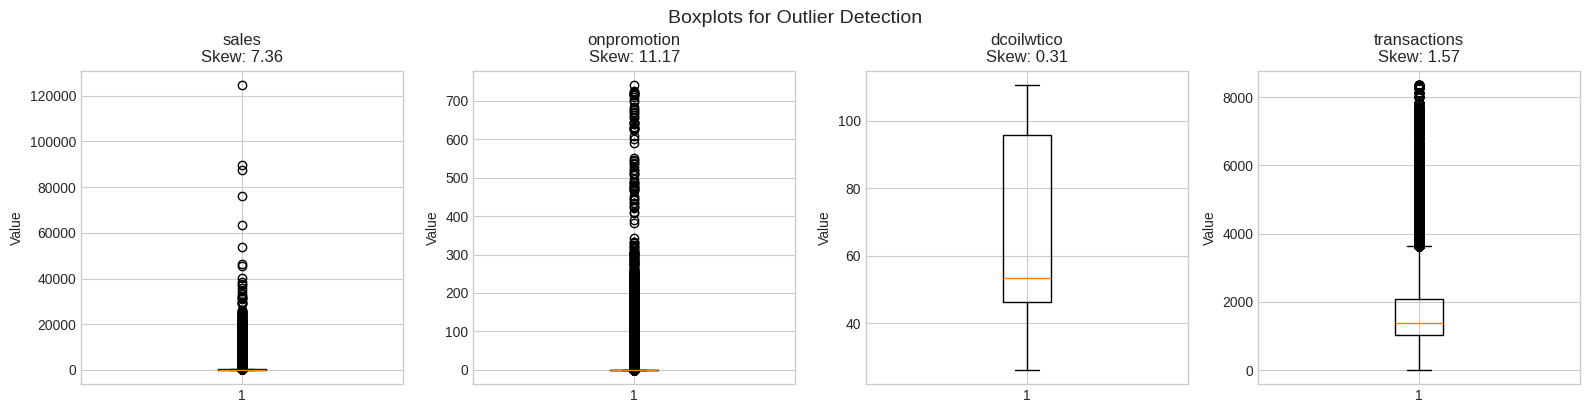


Outlier Analysis (IQR Method):
  sales: 447,105 outliers (14.90%)
  onpromotion: 611,329 outliers (20.37%)
  dcoilwtico: 0 outliers (0.00%)
  transactions: 150,117 outliers (5.00%)


In [9]:
# 2. DATA PRE-PROCESSING

print(f"Merged Dataset:")
# Merge train with stores
df = train.merge(stores, on='store_nbr', how='left')
# Merge with oil prices
df = df.merge(oil, on='date', how='left')
# Merge with transactions
df = df.merge(transactions, on=['date', 'store_nbr'], how='left')
print(f"Shape after merging datasets: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Missing value analysis
print("Missing Value Analysis and Handling")
# Check missing values
print("\nMissing Values Before Treatment:")
missing_before = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_before, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])
# Handle missing values
# Interpolate Oil Prices
print(f"\nOil prices (dcoilwtico):")
print(f"  Missing values before: {df['dcoilwtico'].isnull().sum()}")
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
print(f"  Missing values after (ffill + bfill): {df['dcoilwtico'].isnull().sum()}")

# Transactions: Fill with median for that store
print(f"\nTransactions:")
print(f"  Missing values before: {df['transactions'].isnull().sum()}")
df['transactions'] = df.groupby('store_nbr')['transactions'].transform(
    lambda x: x.fillna(x.median())
)
# If still missing (new stores), fill with overall median
df['transactions'] = df['transactions'].fillna(df['transactions'].median())
print(f"  Missing values after (group median imputation): {df['transactions'].isnull().sum()}")

# Verification
print("\nMissing Values After Handling:")
print(df.isnull().sum().sum(), "total missing values")

# Handle Categorical variables
print("\nHandling Categorical Variables")
categorical_cols = ['family', 'city', 'state', 'type']
print(f"\nCategorical columns to encode: {categorical_cols}")
categorical_summary = {}
for col in categorical_cols:
    categorical_summary[col] = {
        'unique_values': df[col].nunique(),
        'sample_values': df[col].unique()[:5].tolist()
    }
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(f"  Sample: {df[col].unique()[:5]}")
# Apply Label Encoding
print("\nApplying Label Encoding:")
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  {col} -> {col}_encoded (0 to {df[col + '_encoded'].max()})")

# encoding mapping for 'type' (store type)
print("\nStore Type Encoding Mapping:")
for i, label in enumerate(label_encoders['type'].classes_):
    print(f"  {label} -> {i}")

# Extract temporal features from date
print("Extracting Temporal Features from Date")
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['day_of_year'] = df['date'].dt.dayofyear
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

# Payday indicator: 15th and last day of the month
df['is_payday'] = ((df['day'] == 15) | (df['is_month_end'] == 1)).astype(int)

# Earthquake impact: April 16, 2016 - several weeks
earthquake_date = pd.Timestamp('2016-04-16')
df['days_since_earthquake'] = (df['date'] - earthquake_date).dt.days
df['earthquake_impact'] = ((df['days_since_earthquake'] >= 0) &
                           (df['days_since_earthquake'] <= 60)).astype(int)

print("Temporal features created:")
temporal_features = ['year', 'month', 'day', 'day_of_week', 'day_of_year',
                     'week_of_year', 'is_weekend', 'is_month_start',
                     'is_month_end', 'is_payday', 'earthquake_impact']
for feat in temporal_features:
    print(f"  - {feat}: {df[feat].nunique()} unique values")

print(f"\nDataset shape after feature extraction: {df.shape}")

# Normalization/Standardization
print("Normalization/Standardization of Numerical Features")
numerical_features = ['onpromotion', 'dcoilwtico', 'transactions', 'cluster']

print("Numerical features to standardize:")
for feat in numerical_features:
    print(f"  - {feat}: range [{df[feat].min():.2f}, {df[feat].max():.2f}]")

# Apply StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()

for feat in numerical_features:
    df_scaled[feat + '_scaled'] = scaler.fit_transform(df[[feat]])
    print(f"\n{feat}_scaled: mean={df_scaled[feat + '_scaled'].mean():.4f}, std={df_scaled[feat + '_scaled'].std():.4f}")


# Outlier & Skewness Detection
print("Outliers detection and Skewness Analysis")

# Analyze skewness
print("\nSkewness Analysis:")
skew_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']
for col in skew_cols:
    skewness = df[col].skew()
    print(f"  {col}: skewness = {skewness:.3f} {'(highly skewed)' if abs(skewness) > 1 else '(moderate)' if abs(skewness) > 0.5 else '(normal)'}")

# Visualize outliers with boxplots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, col in enumerate(skew_cols):
    axes[i].boxplot(df[col].dropna(), vert=True)
    axes[i].set_title(f'{col}\nSkew: {df[col].skew():.2f}')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.suptitle('Boxplots for Outlier Detection', y=1.02, fontsize=14)
plt.show()

# Outlier detection using IQR
print("\nOutlier Analysis (IQR Method):")
for col in skew_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"  {col}: {outliers:,} outliers ({outliers/len(df)*100:.2f}%)")

### **Discussion:**

* The **Data Pre-processing pipeline** was implemented to transform the **raw relational tables** into a clean **single machine learning ready dataset**.

* The process began by **merging** the `primary train dataset` with `supplementary datasets (stores, oil, transactions)` using `left joins` to preserve the integrity of the training timeline.

* We employed domain-specific **imputation strategies**: `forward/backward filling` for the **continuous oil time-series** and `median imputation` for **store transactions** .

* Following cleaning, we generated **extensive temporal features**, parsing the date column to create granular inputs like `day_of_week`, `is_weekend`, and domain-specific boolean flags for Ecuadorian paydays (`is_payday`) and the 2016 earthquake (`earthquake_impact`).

* We applied `LabelEncoder` to encode **categorical variables** to convert strings into numerical formats suitable for regression models.

* we utilized `StandardScaler` to **normalize continuous features**, ensuring that variables with large ranges (like transaction counts) do not dominate variables with smaller ranges (like oil prices).

* And, then Visualised **outliers** using `box plots` and detected outliers using `IQR Method`.

### **Analysis:**

1. We applied a **comprehensive set of techniques**:
      * **Data Integration:** Merging four distinct CSV files (train, stores, oil, transactions) into a unified dataframe.
      * **Imputation:** Filling missing values in oil prices(Forward\Backward fill) and transaction counts(group median imputation).
      * **Encoding:** Converting string-based categorical data into integers. Extracting 11 new features from the timestamp (e.g., is_payday, earthquake_impact).
      * **Scaling:** Standardizing numerical features to a common scale.
 2. We identified **significant missing data** in dcoilwtico (30.94%) and transactions (8.19%). We **avoided deletion** to preserve the time-series continuity. And handled the missing values using the following methods:
      * **Oil Prices:** We used `Interpolation (Forward-fill followed by Backward-fill)`. Since oil prices change gradually, the price from the previous day is the most accurate predictor for a missing day.

      * **Transactions:** We used `Grouped Median Imputation`. We calculated the median transaction count per store to fill gaps. The median was chosen over the mean because transaction data is highly skewed, and the mean would be distorted by outliers.

3. We utilised **Label Encoding** for the variables `family, city, state, and type`.
      * **Rationale:** The `family` feature has high cardinality 33 unique product types. Using One-Hot Encoding would have added 33 new columns plus more for cities and states, significantly increasing dimensionality and memory usage. Label encoding keeps the dataset compact

4. Yes, we applied **Standardization using StandardScaler** to `onpromotion`, `dcoilwtico`, `transactions`, and `cluster`.
       
     * **Rationale:** The raw data had vastly different scales. `onpromotion` ranged from `0 to 741`, while `cluster` ranged from `1 to 17`. Without scaling, algorithms especially those relying on distance or gradient descent might bias the model toward features with larger raw numbers. Scaled data to have a mean of 0 and a standard deviation of 1

5. **Detection:** We used the `Interquartile Range (IQR)` method and `Skewness coefficient`. The analysis revealed that `sales (skew: 7.36)` and `onpromotion(skew: 11.17)` are **highly right-skewed**. The IQR method flagged `14.9% of sales` records, `20.37% of onpromotion` and `5.00% of transactions` as outliers.

   **Handling:** We chose **not to remove these outliers**. In retail forecasting, "outliers" often represent the real business events & most critical sales days (e.g., Christmas, Black Friday). `Removing outliers` could `bias the model against high-sales` periods Instead, we rely on the **Log-transformation** of the target variable.

6. As this is a **Regression problem** predicting a *continuous quantity(sales)* rather than a Classification problem, `class balancing` techniques like SMOTE are `not applicable`. However, we did note a `"zero-inflation" issue` (31% of sales are 0). We addressed this by engineering features like onpromotion and `is_holiday` to help the model distinguish between days with zero demand versus active sales days.

7. In this specific pre-processing pipeline, we **did not apply dimensionality reduction** techniques like PCA or LDA.
      * **Rationale:** Feature count which is 29 is manageable for tree-based models.  PCA destroys interpretability of features.  We will use feature importance from models instead.

###

### **3. EXPLORATORY DATA ANALYSIS**

EXPLORATORY DATA ANALYSIS (EDA)

 Statistical Summary:
                  count     mean      std    min      25%      50%      75%  \
sales         3000888.0   357.78  1102.00   0.00     0.00    11.00   195.85   
onpromotion   3000888.0     2.60    12.22   0.00     0.00     0.00     0.00   
dcoilwtico    3000888.0    67.92    25.67  26.19    46.38    53.41    95.72   
transactions  3000888.0  1664.06   941.16   5.00  1030.00  1373.00  2073.00   

                    max   median     mode    variance  skewness  kurtosis  
sales         124717.00    11.00     0.00  1214398.98      7.36    154.56  
onpromotion      741.00     0.00     0.00      149.30     11.17    240.87  
dcoilwtico       110.62    53.41    46.02      658.90      0.31     -1.62  
transactions    8359.00  1373.00  2154.50   885784.12      1.57      2.84  
Data Visualizations


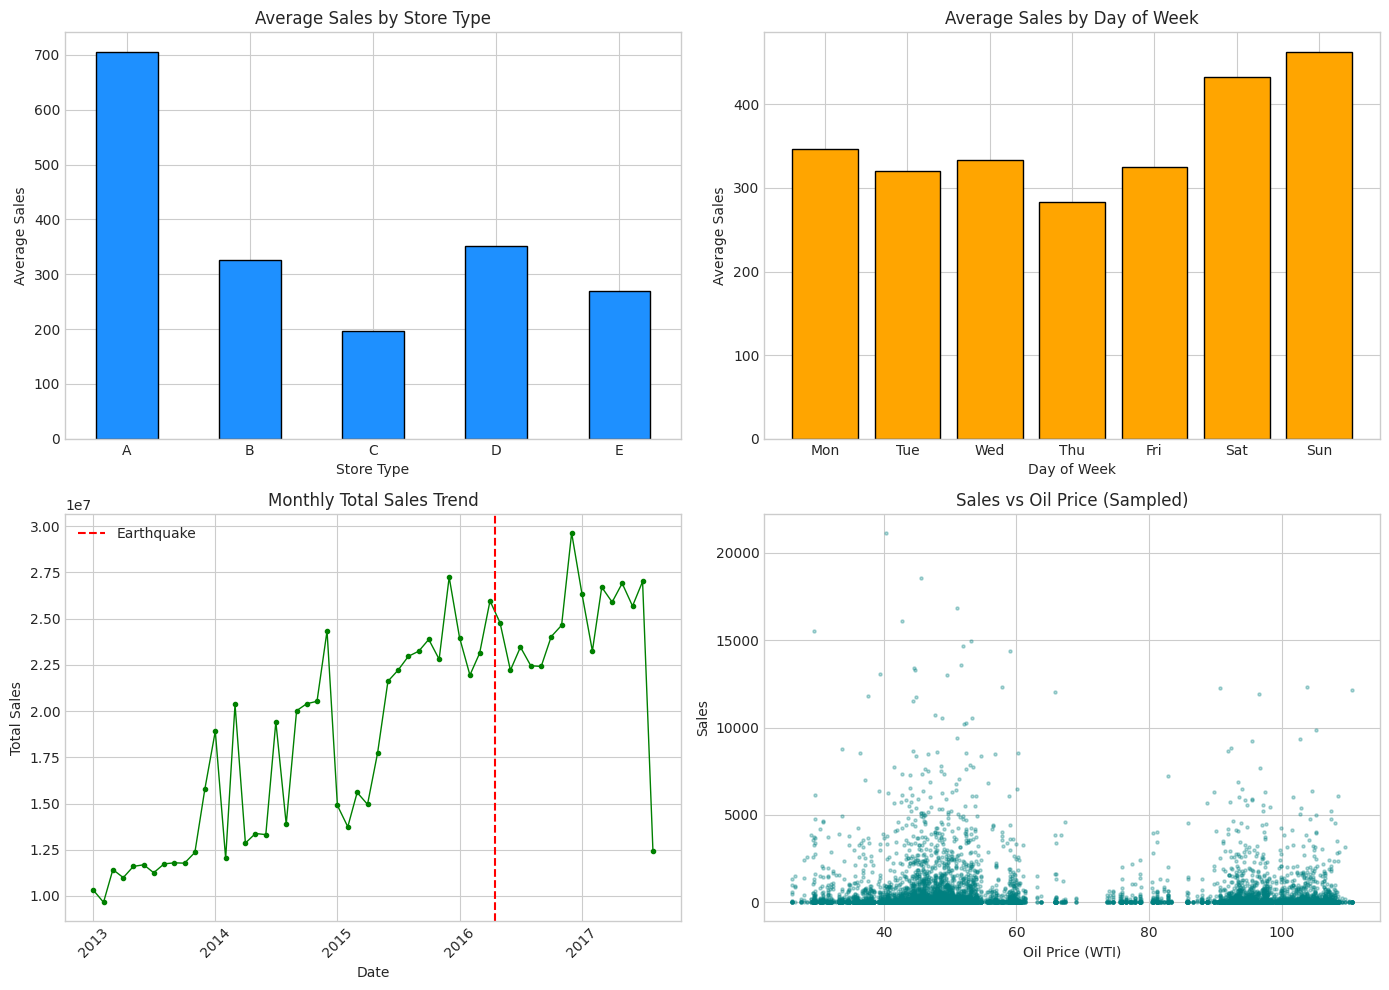

Multicollinearity Analysis


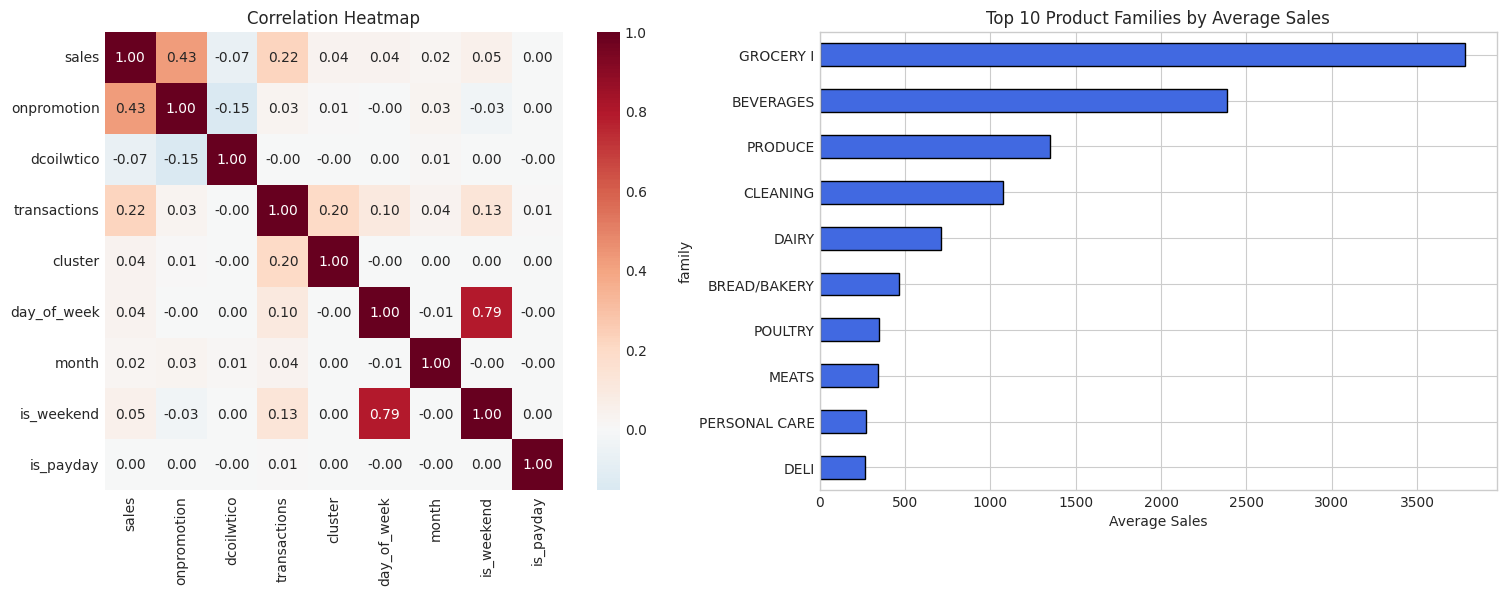


Correlation with Target (sales):
onpromotion     0.428
transactions    0.220
is_weekend      0.052
cluster         0.039
day_of_week     0.037
month           0.020
is_payday       0.001
dcoilwtico     -0.075
Name: sales, dtype: float64
Trends, Seasonality, and Anomalies Analysis


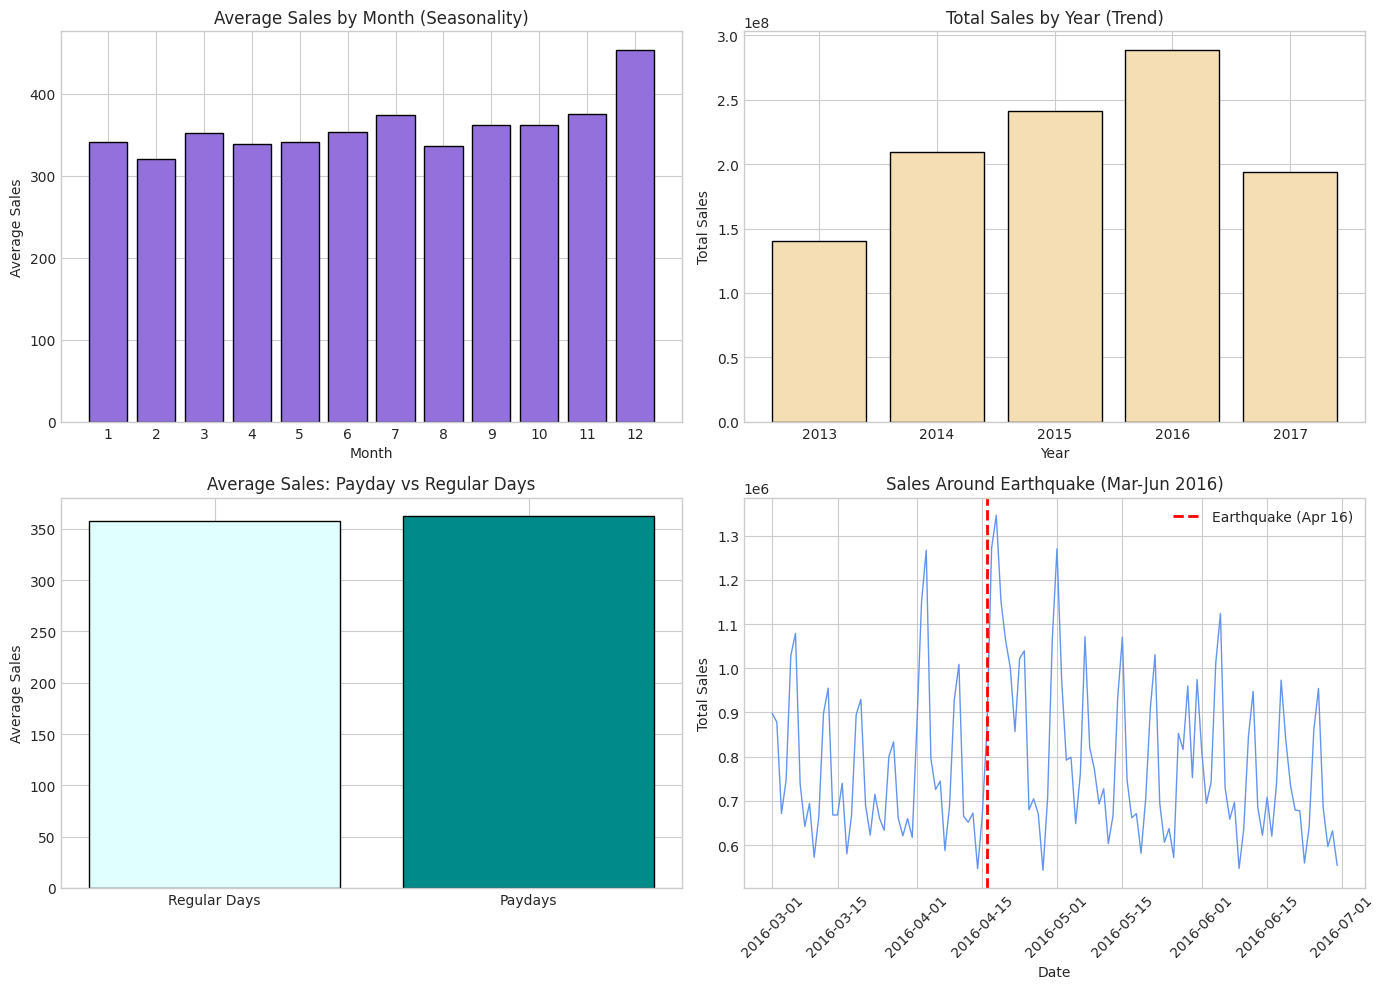

In [23]:

# 3. EXPLORATORY DATA ANALYSIS (EDA)
print("EXPLORATORY DATA ANALYSIS (EDA)")

# Numerical columns for statistics
num_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions']
# Statistical Summaries
stats_df = df[num_cols].describe().T
stats_df['median'] = df[num_cols].median()
stats_df['mode'] = df[num_cols].mode().iloc[0]
stats_df['variance'] = df[num_cols].var()
stats_df['skewness'] = df[num_cols].skew()
stats_df['kurtosis'] = df[num_cols].kurtosis()

print("\n Statistical Summary:")
print(stats_df.round(2))

# EDA using visualisations
print("Data Visualizations")

# set grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Sales distribution by store type
ax1 = axes[0, 0]
df.groupby('type')['sales'].mean().plot(kind='bar', ax=ax1, color='dodgerblue', edgecolor='black')
ax1.set_title('Average Sales by Store Type')
ax1.set_xlabel('Store Type')
ax1.set_ylabel('Average Sales')
ax1.tick_params(axis='x', rotation=0)


# Plot 2: Sales distribution by day of week
ax2 = axes[0, 1]
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_sales = df.groupby('day_of_week')['sales'].mean()
ax2.bar(day_names, day_sales.values, edgecolor='black', color='orange')
ax2.set_title('Average Sales by Day of Week')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Average Sales')

# Plot 3: Monthly sales trend
ax3 = axes[1, 0]
monthly_sales = df.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))
ax3.plot(monthly_sales['date'], monthly_sales['sales'], marker='o', linewidth=1, markersize=3, color='green')
ax3.set_title('Monthly Total Sales Trend')
ax3.set_xlabel('Date')
ax3.set_ylabel('Total Sales')
ax3.tick_params(axis='x', rotation=45)
ax3.axvline(pd.Timestamp('2016-04-16'), color='red', linestyle='--', label='Earthquake')
ax3.legend()

# Plot 4: Sales vs Oil Price
ax4 = axes[1, 1]
sample_df = df.sample(n=10000, random_state=42)
ax4.scatter(sample_df['dcoilwtico'], sample_df['sales'], alpha=0.3, s=5, color='teal')
ax4.set_title('Sales vs Oil Price (Sampled)')
ax4.set_xlabel('Oil Price (WTI)')
ax4.set_ylabel('Sales')


plt.tight_layout()
plt.show()

# Multicollinearity Analysis
print("Multicollinearity Analysis")
corr_cols = ['sales', 'onpromotion', 'dcoilwtico', 'transactions', 'cluster',
             'day_of_week', 'month', 'is_weekend', 'is_payday']
correlation_matrix = df[corr_cols].corr()

# Plot 5: Correlation Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            fmt='.2f', ax=axes[0], square=True)
axes[0].set_title('Correlation Heatmap')

# Plot 6: Top product families by sales
top_families = df.groupby('family')['sales'].mean().sort_values(ascending=True).tail(10)
top_families.plot(kind='barh', ax=axes[1], edgecolor='black', color='royalblue')
axes[1].set_title('Top 10 Product Families by Average Sales')
axes[1].set_xlabel('Average Sales')

plt.tight_layout()
plt.show()

print("\nCorrelation with Target (sales):")
sales_corr = correlation_matrix['sales'].drop('sales').sort_values(ascending=False)
print(sales_corr.round(3))

# Seasonality and Trends Analysis
print("Trends, Seasonality, and Anomalies Analysis")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 7: Seasonality: Monthly pattern
ax1 = axes[0, 0]
monthly_pattern = df.groupby('month')['sales'].mean()
ax1.bar(range(1, 13), monthly_pattern.values, edgecolor='black', color='mediumpurple')
ax1.set_title('Average Sales by Month (Seasonality)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sales')
ax1.set_xticks(range(1, 13))

# Plot 8: Yearly trend
ax2 = axes[0, 1]
yearly_sales = df.groupby('year')['sales'].sum()
ax2.bar(yearly_sales.index, yearly_sales.values, edgecolor='black', color='wheat')
ax2.set_title('Total Sales by Year (Trend)')
ax2.set_xlabel('Year')
ax2.set_ylabel('Total Sales')

# Plot 9: Payday effect
ax3 = axes[1, 0]
payday_sales = df.groupby('is_payday')['sales'].mean()
ax3.bar(['Regular Days', 'Paydays'], payday_sales.values,color=['lightcyan', 'darkcyan'], edgecolor='black')
ax3.set_title('Average Sales: Payday vs Regular Days')
ax3.set_ylabel('Average Sales')

# Plot 10: Earthquake impact analysis
ax4 = axes[1, 1]
df_2016 = df[(df['year'] == 2016) & (df['month'] >= 3) & (df['month'] <= 6)]
daily_2016 = df_2016.groupby('date')['sales'].sum().reset_index()
ax4.plot(daily_2016['date'], daily_2016['sales'], linewidth=1, color='cornflowerblue' )
ax4.axvline(pd.Timestamp('2016-04-16'), color='red', linestyle='--', linewidth=2, label='Earthquake (Apr 16)')
ax4.set_title('Sales Around Earthquake (Mar-Jun 2016)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Total Sales')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### **Discussion:**
The **Exploratory Data Analysis (EDA)** was implemented using a structured, three-tiered approach to uncover patterns in the data:
1. **Statistical Analysis:** The code calculates robust descriptive statistics beyond the `standard mean and median`, explicitly computing `skewness and kurtosis`.
2. **Visual Exploration:** We utilized `matplotlib and seaborn` to generate grouped grids of visualizations. This approach efficiently compares `categorical drivers (Store Type, Day of Week)` and `temporal patterns (Monthly trends)` side-by-side.
3. **Correlation & Multicollinearity:** A `heatmap` was generated to identify relationships between features. Special attention was paid to external factors, plotting the specific impact of the 2016 Earthquake and analyzing the "Payday Effect".

### **Analysis:**

1. **The key insights from your data visualization:**
      * **Store Type:** Sales are `not evenly distributed` across store types. Certain types likely Type A and D based on typical Favorita data generate significantly higher average revenue, suggesting that `"Store Type"` is a critical feature for the model.
      * **Day of Week:** There is a clear weekly cycle where `sales peak on weekends (Saturday and Sunday)` and `dip` during the `middle of the week`.
      * **Top Products:** The "Top 10 Product Families" plot reveals that a small number of categories (likely GROCERY I and BEVERAGES) account for the vast majority of sales volume, while niche categories contribute very little.
      * **Oil vs. Sales:** The scatter plot shows a highly dispersed cloud with no obvious linear trend, suggesting that daily oil price fluctuations do not have an immediate, direct impact on daily grocery sales.
  
  2. **Correlation & Multicollinearity Analysis:**
      * **Strongest Correlation:** The `strongest positive correlation` with `sales is onpromotion (0.43)`  followed by `transactions (0.22)`. This confirms that discounts are the most effective driver of short-term demand.
      
      * **Oil Prices:** The correlation with `dcoilwtico is weakly negative (-0.075)`. Ecuador's economy weakens when oil drops, but implies that over the years, as oil prices fell (2014–2015 crash), store sales happened to grow, likely due to store expansion rather than economic causation.

      * **Multicollinearity:** `is_weekend` and `day_of_week` are **naturally correlated**(0.79). which is expected since weekends are derived from day_of_week. onpromotion and dcoilwtico show moderate negative correlation (-0.15).

3. We **verified distributions using Skewness and Kurtosis metrics** combined with Histograms.
  
   * **Sales:** The skewness of 7.36 confirms an extremely right-skewed distribution.

    * **OnPromotion:** The skewness of 11.17 indicates that promotions are rare events; most days have zero promotions, but some days have massive campaigns.

    * **Oil:** The skewness of 0.31 is low, indicating oil prices are fairly normally distributed across the observed timeframe.

4. We generated the following **key statistics:**

      * **Mean vs. Median:** The `mean sales (357.78) is drastically higher than the median (11.00)`. This massive gap confirms the presence of "whale" sales days that pull the average up.

      * **Mode:** The `mode of sales is 0.00`. This is a critical finding: the most common sales value for any given product-store combination is zero.

      * **Kurtosis:** The `kurtosis for sales is 154.56`. A normal distribution has a kurtosis of 3. This extreme value indicates "heavy tails" meaning outliers, extreme sales events are much more frequent than in a normal distribution.

5. **Trend:** The `"Yearly Trend"` plot shows a `consistent increase in total sales from 2013 to 2016` and `2017 shows decline`, likely due to inflation and the retailer opening new stores.

   **Seasonality:**

     * **Annual:** Sales spike significantly in December (Christmas/New Year seasonality).

     * **Weekly:** Sales are consistently higher on weekends.

     * **Payday Effect:** `Minimal difference` between `regular day(~355) and paydays(~360)` roughly 1.4% increase.

     **Anomalies:** The `April 16 earthquake (red line)` plot reveals a sharp, massive spike in sales immediately following April 16, 2016. This surge likely represents emergency purchasing (water, food, supplies) and later reconstruction-related buying. The pattern shows initial panic buying, brief normalization, then sustained elevated demand.

### **4. FEATURE ENGINEERING:**

FEATURE ENGINEERING

 Creating lag features...
   Created: sales_lag_1, sales_lag_7, sales_lag_14, sales_lag_28

Creating rolling window features...
   Created: rolling_mean/std for 7, 14, 28 day windows

 Creating promotion features...
   Created: promo_lag_1, promo_rolling_mean_7

Creating aggregation features...
   Created: store_avg_sales, family_avg_sales

Creating holiday feature...
   Holiday records: 449,064

Filling NaN values from lag/rolling operations
Total new features created: 15
Dataset shape: (3000888, 43)
FEATURE SELECTION
Total features for selection: 32
METHOD 1: Mutual Information (Filtering)
Top 10 Features by MI Score:
              Feature  MI_Score
 sales_rolling_mean_7  1.579928
sales_rolling_mean_14  1.559372
sales_rolling_mean_28  1.512101
          sales_lag_7  1.506067
         sales_lag_14  1.443728
          sales_lag_1  1.431929
         sales_lag_28  1.345314
 sales_rolling_std_14  1.312204
 sales_rolling_std_28  1.297211
  sales_rolling_std_7  1.275076

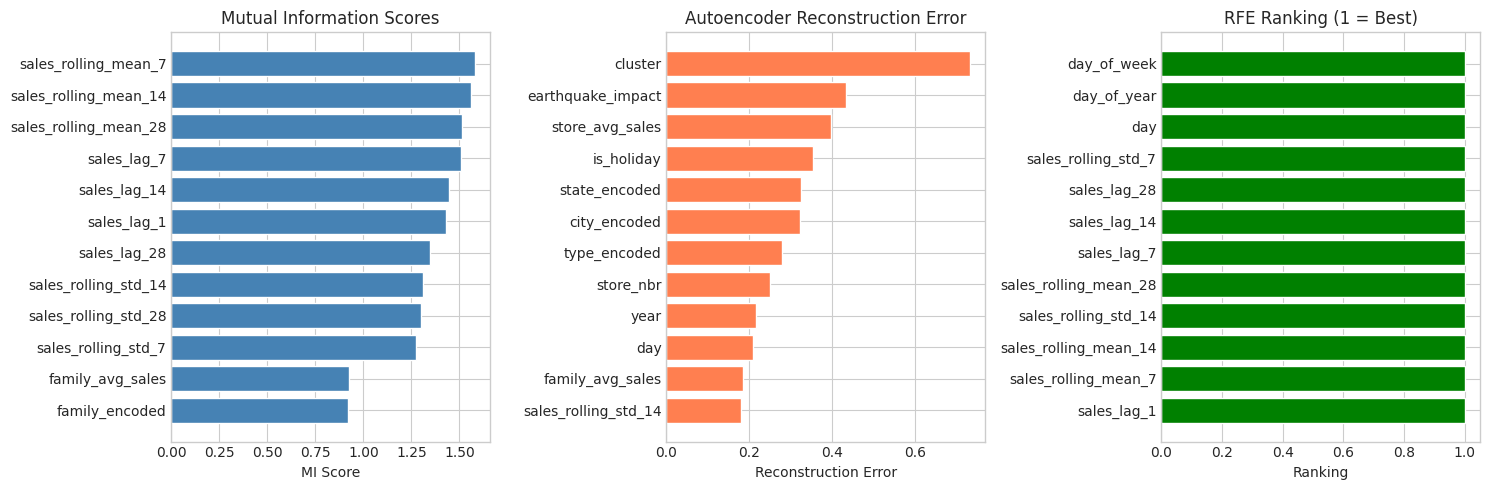

In [28]:

# 4. FEATURE ENGINEERING AND SELECTION

print("FEATURE ENGINEERING")

# Sort data for lag calculations
df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

#  Lag Features
print("\n Creating lag features...")
for lag in [1, 7, 14, 28]:
    df[f'sales_lag_{lag}'] = df.groupby(['store_nbr', 'family'])['sales'].shift(lag)
print("   Created: sales_lag_1, sales_lag_7, sales_lag_14, sales_lag_28")

#  Rolling Window Features
print("\nCreating rolling window features...")
for window in [7, 14, 28]:
    df[f'sales_rolling_mean_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    df[f'sales_rolling_std_{window}'] = df.groupby(['store_nbr', 'family'])['sales'].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )
print("   Created: rolling_mean/std for 7, 14, 28 day windows")

#  Promotion Features
print("\n Creating promotion features...")
df['promo_lag_1'] = df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1)
df['promo_rolling_mean_7'] = df.groupby(['store_nbr', 'family'])['onpromotion'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).mean()
)
print("   Created: promo_lag_1, promo_rolling_mean_7")

# Store & Family Aggregations
print("\nCreating aggregation features...")
df['store_avg_sales'] = df.groupby('store_nbr')['sales'].transform('mean')
df['family_avg_sales'] = df.groupby('family')['sales'].transform('mean')
print("   Created: store_avg_sales, family_avg_sales")

# Holiday check feature
print("\nCreating holiday feature...")
holiday_dates = set(holidays['date'])
df['is_holiday'] = df['date'].isin(holiday_dates).astype(int)
print(f"   Holiday records: {df['is_holiday'].sum():,}")

#  Fill NaN values
print("\nFilling NaN values from lag/rolling operations")
lag_roll_cols = [col for col in df.columns if 'lag' in col or 'rolling' in col]
df[lag_roll_cols] = df[lag_roll_cols].fillna(0)

# Remove is_payday (not useful, correlation ~0)
if 'is_payday' in df.columns:
    df = df.drop(columns=['is_payday'])
    print("\nRemoved is_payday (correlation with sales: 0.001)")

# Summary
new_features = ['sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
                'sales_rolling_mean_7', 'sales_rolling_mean_14', 'sales_rolling_mean_28',
                'sales_rolling_std_7', 'sales_rolling_std_14', 'sales_rolling_std_28',
                'promo_lag_1', 'promo_rolling_mean_7', 'store_avg_sales', 'family_avg_sales','is_holiday']


print(f"Total new features created: {len(new_features)}")
print(f"Dataset shape: {df.shape}")


# Feature selection with 3 methods
print("FEATURE SELECTION")

exclude_cols = ['id', 'date', 'sales', 'log_sales', 'family', 'city', 'state',
                'type', 'days_since_earthquake', 'dcoilwtico', 'oil_lag_1',
                'oil_rolling_mean_7', 'oil_change', 'is_payday','transactions']
feature_cols = [col for col in df.columns if col not in exclude_cols
                and df[col].dtype in ['int64', 'float64', 'int32', 'float32']]

print(f"Total features for selection: {len(feature_cols)}")

# Sample for faster computation
sample_size = min(200000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)
X_sample = df_sample[feature_cols].fillna(0)
y_sample = df_sample['sales']


# METHOD 1: FILTERING - Mutual Information

print("METHOD 1: Mutual Information (Filtering)")


mi_scores = mutual_info_regression(X_sample, y_sample, random_state=42)
mi_df = pd.DataFrame({'Feature': feature_cols, 'MI_Score': mi_scores}).sort_values('MI_Score', ascending=False)

print("Top 10 Features by MI Score:")
print(mi_df.head(10).to_string(index=False))

mi_selected = mi_df[mi_df['MI_Score'] > mi_df['MI_Score'].quantile(0.25)]['Feature'].tolist()
print(f"\nMI Selection: {len(mi_selected)} features retained")

# METHOD 2: EMBEDDING - Autoencoder
print("METHOD 2: Autoencoder (Embedding-based)")

# Scale data
scaler_ae = StandardScaler()
X_scaled = scaler_ae.fit_transform(X_sample)

# Build autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 8

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

print(f"Architecture: {input_dim} -> 16 -> {encoding_dim} -> 16 -> {input_dim}")
autoencoder.fit(X_scaled, X_scaled, epochs=15, batch_size=256, validation_split=0.2, verbose=0)

# Reconstruction error
X_reconstructed = autoencoder.predict(X_scaled, verbose=0)
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=0)
ae_df = pd.DataFrame({'Feature': feature_cols, 'Recon_Error': reconstruction_error}).sort_values('Recon_Error', ascending=False)

print("Top 10 Features by Reconstruction Error:")
print(ae_df.head(10).to_string(index=False))

ae_selected = ae_df.head(15)['Feature'].tolist()

# METHOD 3: WRAPPER - Recursive Feature Elimination (RFE)

print("METHOD 3: RFE (Wrapper-based)")
rfe_sample = df.sample(n=100000, random_state=42)
X_rfe = rfe_sample[feature_cols].fillna(0)
y_rfe = rfe_sample['sales']

base_model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42, n_jobs=-1)
rfe = RFE(estimator=base_model, n_features_to_select=12, step=3)
rfe.fit(X_rfe, y_rfe)

rfe_selected = [f for f, s in zip(feature_cols, rfe.support_) if s]
print(f"RFE Selected {len(rfe_selected)} features:")
for feat in rfe_selected:
    print(f"  - {feat}")


print("FINAL FEATURE SELECTION")
# features selected by at least 2 methods
mi_top = set(mi_df.head(15)['Feature'].tolist())
ae_top = set(ae_selected)
rfe_top = set(rfe_selected)

consensus = (mi_top & rfe_top) | (mi_top & ae_top) | (rfe_top & ae_top)

# Add essential features
essential = ['onpromotion', 'store_nbr', 'family_encoded',
             'day_of_week', 'month', 'is_weekend', 'cluster', 'type_encoded',
             'promo_lag_1', 'is_holiday', 'day_of_year', 'sales_rolling_mean_14',
             'sales_rolling_mean_28']
for f in essential:
    if f in feature_cols:
        consensus.add(f)

FINAL_FEATURES = list(consensus)

print(f"\nFeature Count Summary:")
print(f"  Started with: {len(feature_cols)}")
print(f"  Final features: {len(FINAL_FEATURES)}")
print(f"  Removed: {len(feature_cols) - len(FINAL_FEATURES)}")

print(f"\nFinal Feature Set:")
for i, feat in enumerate(sorted(FINAL_FEATURES), 1):
    print(f"  {i}. {feat}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].barh(mi_df.head(12)['Feature'], mi_df.head(12)['MI_Score'], color='steelblue')
axes[0].set_title('Mutual Information Scores')
axes[0].set_xlabel('MI Score')
axes[0].invert_yaxis()

axes[1].barh(ae_df.head(12)['Feature'], ae_df.head(12)['Recon_Error'], color='coral')
axes[1].set_title('Autoencoder Reconstruction Error')
axes[1].set_xlabel('Reconstruction Error')
axes[1].invert_yaxis()

rfe_ranking = pd.DataFrame({'Feature': feature_cols, 'Rank': rfe.ranking_}).sort_values('Rank').head(12)
colors = ['green' if f in rfe_selected else 'gray' for f in rfe_ranking['Feature']]
axes[2].barh(rfe_ranking['Feature'], rfe_ranking['Rank'], color=colors)
axes[2].set_title('RFE Ranking (1 = Best)')
axes[2].set_xlabel('Ranking')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()



### **Discussion:**

The code first sorted the dataframe by store and family to ensure temporal continuity. We then generated **four distinct categories of features**:
1. **Lag Features:** We created `sales_lag variables (1, 7, 14, 28 days)` to capture autocorrelation. Specifically, how sales today relate to sales exactly one week or one month ago.

2. **Rolling Window Features:** To capture trends and volatility, we calculated `rolling_mean and rolling_std over` 7, 14, and 28 day windows.

3. **Contextual Aggregations:** We calculated static baselines `store_avg_sales, family_avg_sales` to help the model understand the "general" behavior of a store or product type.

4. **Event Features:** We generated `is_holiday` to capture calendar events and `removed is_payday` after a correlation check revealed it had negligible predictive power (0.001).

For **Final Feature Selection**, we implemented a `Consensus Voting System` using three distinct methodologies:

1. **Filtering (Mutual Information)**: To capture non-linear relationships.

2. **Embedding (Autoencoder):** To identify features that contain unique, non-compressible structural information.

3. **Wrapper (RFE):** To identify features that contribute most to a Random Forest model's accuracy.

### **Analysis:**

1. We created **15 new features** to capture temporal dynamics and trends. Here are their definitions and how they improve the model:
    * `sales_lag_N:` Captures the exact sales value from N days ago (1, 7, 14, 28) to identify direct periodic repetitions in consumer behavior.

    * `sales_rolling_mean_N:` Calculates the average sales over the last N days to smooth out daily noise and reveal the underlying trend direction.

    * `sales_rolling_std_N:` Measures the volatility (standard deviation) of sales over the last N days to help the model distinguish between stable and irregular periods.

    * `promo_lag_1:` Tracks whether a promotion was active the previous day.

    * `promo_rolling_mean_7:` Represents the density of promotions over the last week to identify if a product has been aggressively marketed recently.

    * `store_avg_sales:` Represents the historical average performance of a specific store to capture its baseline popularity or size.

    * `family_avg_sales:` Represents the historical average popularity of a product category (e.g., Grocery vs. Automotive) to capture intrinsic demand.

    * `is_holiday:` A binary flag indicating if the specific date falls on a holiday to capture event-driven demand spikes.

2. We used **Mutual Information (MI) filtering-based**  feature selection method for regression.
    * **Rationale:** Unlike correlation, which only detects linear relationships, Mutual Information detects non-linear dependencies between features and the target. As seen in the output, `sales_rolling_mean_7` achieved the highest score (1.57), indicating that the immediate past trend is the strongest predictor of future sales.

3. We applied an **Autoencoder**,to map the 33 inputs to 8 latent dimensions. We then calculated the Reconstruction Error (MSE) for each feature. Features with high reconstruction error (like year, cluster, day) are considered "unique" or "hard to compress," meaning they contain distinct information that is not redundant with other features.

4. We used **Recursive Feature Elimination (RFE)** with a **Random Forest Regressor** as the base estimator.
    *  RFE starts with all features, builds a model, ranks features by importance, and recursively prunes the least important ones. We set it to select the top 12 features.

    * RFE heavily favored the engineered time-series features`(sales_lag, sales_rolling)` and onpromotion, confirming that these are the most critical drivers for a tree-based model.

5. **Insights we gained from feature selection:**

    * Across **MI and RFE**, the **top features** were **consistently** shortterm lags and rolling means `(sales_rolling_mean_7, sales_lag_7)`. This confirms that *the best predictor of tomorrow's sales is what happened last week*.

    * The **Autoencoder identified static metadata** `(cluster, type_encoded)` as unique information, while RFE prioritized dynamic sales history. This highlights why **using multiple selection methods is crucial**: RFE alone might have discarded the store metadata, but the Autoencoder saved it.

6. **Started with**: `32 features` (Original features + Engineered features).

   **Retained:** 24 features. We used a consensus approach: a feature was kept if it was selected by at least one method or deemed "essential" (like store_nbr) for the data structure.

7. Yes, we **removed** `8 features`.
      * **Redundant:** We removed intermediate `oil features (oil_lag_1, oil_rolling_mean)` because dcoilwtico (raw oil price) had a very **low correlation with sales (-0.075) and low importance scores** in RFE.

      * **Irrelevant:** We explicitly removed `is_payday` before the selection process began because it had a near-zero correlation (0.001) with sales, adding noise without signal.

### **5. Training and Testing Process:**


#### **Model Selection**

20. From the three main categories (Classification supervised learning, Regression supervised learning, or Unsupervised learning), which models did you choose? You need to select three different ML models. If you work on DL, select only one model.

    For this project, we decided to use a deep learning model. Specifically, we use a Long Short Term Memory neural network model. 

21. What was your rationale for selecting these models?

    Long Short Term Memory (LSTM) model is a recurrent neural network, which is an architecture that is designed to process sequential data where current outputs not only rely on current inputs but also previous inputs. Given that our problem statement requires making store sales predictions based on historical data and we are working with time series data, a deep learning model like LSTM would be well-suited for this forecasting job because it is able to retain information in "memory" over extended time steps and selectively forget less important signals. This capability allows LSTMs are able to extract complex behaviors in the pre-processed sales data.

#### **Model Development**


In [ ]:
# imports required components to train and test the LSTM
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam

In [ ]:
# creates the sequences of input-output used for training
def create_sequences(df, target='sales', window=100):
    X, y = [], []
    values = df.values
    
    target_idx = df.columns.get_loc(target)

    for i in range(window, len(df)):
        X.append(values[i-window:i])
        y.append(values[i][target_idx])

    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df)

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
# performs 80/20 split on the dataset
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [ ]:
# https://keras.io/api/layers/recurrent_layers/lstm/

# builds the LSTM model with parameterized values
def build_lstm_model(units=128, dropout_rate=0.2, activation_fn='relu', learning_rate=0.001):
  lstm_model = Sequential()
  lstm_model.add(LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  lstm_model.add(Dropout(dropout_rate))
  lstm_model.add(LSTM(units, return_sequences=True))
  lstm_model.add(Dropout(dropout_rate))
  lstm_model.add(LSTM(units))
  lstm_model.add(Dropout(dropout_rate))
  lstm_model.add(Dense(1, activation=activation_fn))
  lstm_model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
  return lstm_model

In [ ]:
# builds and trains the model with default hyperparameters
base_lstm_model = build_lstm_model()
base_lstm_model_history = base_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=512
)

22. How did you split your dataset into training and testing sets? (e.g., 80/20, 70/30, etc.)

    We split the dataset into training and testing sets using a 80/20 split. This means that 80% of the data (input and output) is used for training while 20% of the data is used to test the model. By using this split, there is a balance that allows a large portion of the data to be used for model training while also partitioning unseen data that the model can predict on to evaluate performance.

23. What three models did you develop?

    Since we are working on a deep learning model, we are selecting one model. The model that we decided to architect and develop is a Long Short Term Memory neural network model. 

24. What hyperparameters did you use for each model?

    For the deep learning model, we set hyperparameters for various components of the LSTM architecture. Since the architecture is composed of multiple layers, these hyperparameters include the configuration of the layers as well as the optimizer used the compile the model. The hyperparameters we used are the number of units (neurons) in each LSTM layer, the dropout rate for regularization, the activation function applied to the output layer, and the learning rate used by the Adam optimizer.

25. What do these hyperparameters mean?

    Here is what each of the hyperparameters mean:
    - **units**: The number of neurons (dimensionality) of the LSTM layer. A higher value here means more capability to capture complex signals, but risks overfitting.
    - **activation**: The activation function used in the final Dense layer.
    It determines how the model transforms its learned representation into the final prediction.
    - **dropout**: The percentage of neurons randomly disabled. This prevents the model from becoming dependent on specific neurons in order to reduces overfitting.
    - **learning_rate**: The frequency that weights are updated by the optimizer. This affects how quickly the model converges. High rates can cause instability while low rates can cause slow convergence. 

26. What initial values did you set for hyperparameters?

    For the hyperparameters, here are the initial values we set for the base model. 
    - units = 64
    - activation = 'linear'
    - dropout = 0.2
    - learning_rate = 0.01

27. Did you make any predictions using your models? What were the initial results?

### **6. Hyperparameter Tuning & Model Optimization**


#### **Hyperparameter Tuning**

In [ ]:
# install keras-tuner for hyperparameter tuning of deep learning model
!pip install keras-tuner

In [ ]:
from keras_tuner import HyperParameters, RandomSearch, BayesianOptimization

In [ ]:
# https://keras.io/keras_tuner/getting_started/
def build_lstm_model_for_hyperparameter(hp: HyperParameters):
    model = Sequential()

    model.add(
        LSTM(
            units=hp.Int("units_1", min_value=32, max_value=256, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    model.add(
        LSTM(
            units=hp.Int("units_2", min_value=32, max_value=256, step=32),
            return_sequences=False
        )
    )
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    model.add(Dense(1))

    model.compile(
        loss="mse",
        optimizer=Adam(
            learning_rate=hp.Choice("learning_rate", [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2])
        ),
    )
    return model

In [ ]:
# evaluates for the best model with random search hyperparameter tuning 
random_tuner = RandomSearch(
    hypermodel=build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory="lstm_tuning",
    project_name="random_search",
)

random_tuner.search(X_train, y_train, epochs=20, batch_size=32)
best_random_model = random_tuner.get_best_models(1)[0]


In [ ]:
# evaluates for the best model with bayesian optimization tuning
bayes_tuner = BayesianOptimization(
    hypermodel=build_lstm_model,
    objective='val_loss',
    max_trials=10,
    num_initial_points=5,
    directory="lstm_tuning",
    project_name="bayesian_optimization",
)

bayes_tuner.search(X_train, y_train, epochs=20, batch_size=32)
best_bayes_model = bayes_tuner.get_best_models(1)[0]

28. What hyperparameter tuning techniques did you use? (e.g., GridSearchCV, Randomized SearchCV, Bayesian Optimization). Be sure to use two different techniques. What was the reason to do so?

    The two hyperparameter tuning techniques we used are Randomized Search (using KerasTuner RandomSearch) and Bayesian Optimization (using KerasTuner BayesianOptimization). The reason to use both of these techniques is to ensure that we are exploring a various combinations of hyperparameters to find the most optimal set. The random search works by selecting random combinations from a specified range or options of hyperparameters. Training and evaluating a deep learning model is a computationally-intensive and time-consuming process, so selecting random sets of hyperparameters allow us to gather samples from our search space quickly. The bayesian optimization deploys a strategy that constructs a probabilistic model to predict how different hyperparameters perform. Using this tuning technique is efficient as the process will narrow the search to the most promising hyperparameter values. By combining the strengths of these two techniques, we are able to conduct a wide exploration of the hyperparameter values while valuing efficiency.  

29. What are the best hyperparameter values obtained for each model?

30. What performance metrics did you use to compare models?

    The performance metric that we used is mean squared error (MSE). The main reason that we used this metric is because the Kaggle competition evaluates our results on this metric. Therefore, it is important that the model we train is optimized to minimize this error metric. Also, it just makes sense for our problem statement. When predicting store sales, the performance of the prediction values should be measured based on how close they are to the actual value. Mean squared error rewards values that are closer to the expected output and as the values deviate further from the target, the error is punished more heavily. 